In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Загрузка и предобработка данных

In [3]:
path = r"C:\Users\abely\OneDrive\Desktop\tomograph\csv"
all_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]

In [4]:
# Загрузка всех CSV файлов и объединение в один df
df_list = []
for f in all_files:
    try:
        df_temp = pd.read_csv(f, sep=';', encoding='cp1251')
        df_list.append(df_temp)
    except Exception as e:
        print(f"Ошибка при чтении файла {f}: {e}")

df = pd.concat(df_list, ignore_index=True)

In [5]:
df

,FileName,Depth,X,Y,R,S,Rhob_0-256,S_0-256,Por_0-256,Rhob_0-40,S_0-40,Por_0-40,N,Depth.1
0,M:\AG-150 metrov\06.02.2023\srezy\3652.70-3653...,3652.7000,264,273,184,91542,2.723392,91542,100.0,NaN,0,NaN,40,3652.7000
1,M:\AG-150 metrov\06.02.2023\srezy\3652.70-3653...,3652.7006,264,273,184,91542,2.755608,91542,100.0,NaN,0,NaN,41,3652.7006
2,M:\AG-150 metrov\06.02.2023\srezy\3652.70-3653...,3652.7012,264,273,184,91542,2.747085,91542,100.0,NaN,0,NaN,42,3652.7012
3,M:\AG-150 metrov\06.02.2023\srezy\3652.70-3653...,3652.7018,264,273,184,91542,2.721850,91542,100.0,NaN,0,NaN,43,3652.7018
4,M:\AG-150 metrov\06.02.2023\srezy\3652.70-3653...,3652.7024,264,273,184,91542,2.722243,91542,100.0,NaN,0,NaN,44,3652.7024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248130,M:\AG-150 metrov\03.02.2023\srezy\3805.75-3806...,3806.4550,255,252,182,11610,2.653192,11610,100.0,NaN,0,NaN,1205,3806.4550
248131,M:\AG-150 metrov\03.02.2023\srezy\3805.75-3806...,3806.4556,255,252,182,11610,2.656400,11610,100.0,NaN,0,NaN,1206,3806.4556
248132,M:\AG-150 metrov\03.02.2023\srezy\3805.75-3806...,3806.4562,255,252,182,11610,2.660601,11610,100.0,NaN,0,NaN,1207,3806.4562
248133,M:\AG-150 metrov\03.02.2023\srezy\3805.75-3806...,3806.4568,255,252,182,11610,2.652930,11610,100.0,NaN,0,NaN,1208,3806.4568


In [9]:
# Фильтрация и подготовка данных
df_clean = df.dropna(subset=['Rhob_0-256', 'Depth']).copy()
Rhob = df_clean['Rhob_0-256'].values
Depth = df_clean['Depth'].values

# Удаление дубликатов по глубине, если есть
unique_depths, indices = np.unique(Depth, return_index=True)
Rhob = Rhob[indices]
Depth = unique_depths

# Расчет параметров среды

In [11]:
# Формула Гарднера 
Vp = 0.31 * (Rhob ** 0.25) 

In [9]:
# Удаление дубликатов и проверка порядка глубин
Depth, unique_indices = np.unique(Depth, return_index=True)
Rhob = Rhob[unique_indices]
Depth.sort()

In [10]:
# Расчет времени двойного пробега (TWT)
twt = np.zeros_like(Depth)
for i in range(1, len(Depth)):
    dz = Depth[i] - Depth[i-1]
    twt[i] = twt[i-1] + 2 * dz / Vp[i-1] 

In [13]:
# Коэффициенты отражения
Z = Rhob * Vp
R = (Z[1:] - Z[:-1]) / (Z[1:] + Z[:-1])
R_clean = np.nan_to_num(R)
R_clean[np.abs(R_clean) < 0.01] = 0.0
times_mid = (twt[:-1] + twt[1:]) / 2  # Время для коэффициентов

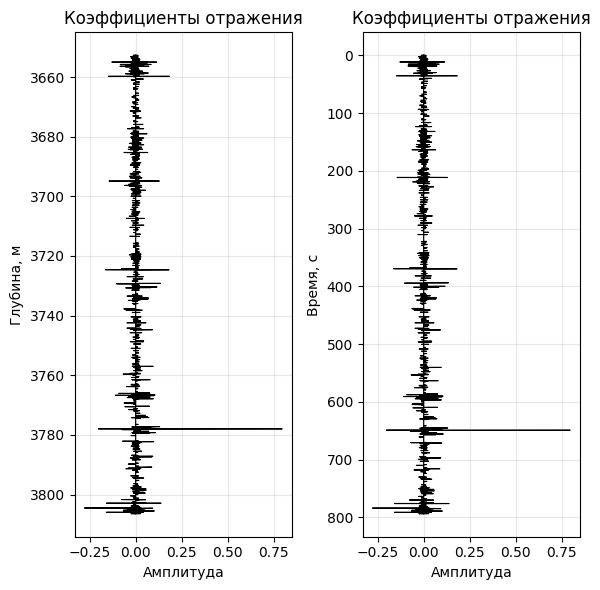

In [15]:
# Визуализация коэффициентов отражения
plt.figure(figsize=(6, 6)) 

# График коэффициентов отражения vs глубина
plt.subplot(121)
plt.plot(R_clean, Depth[:-1], 'k', linewidth=0.8)
plt.title('Коэффициенты отражения')
plt.xlabel('Амплитуда')
plt.ylabel('Глубина, м')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# График коэффициентов отражения vs время
plt.subplot(122)
plt.plot(R_clean, times_mid, 'k', linewidth=0.8)
plt.title('Коэффициенты отражения')
plt.xlabel('Амплитуда')
plt.ylabel('Время, с')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Определение импульсов 

In [17]:
def impulse_berlage(t, f=20, b=35, n=2):
    """Импульс Берлаге (t >= 0)"""
    return (t ** n) * np.exp(-b * t) * np.sin(2 * np.pi * f * t)

def impulse_gelfand(t, f=20, b=0.5):
    """Импульс Гельфанда (t >= 0)"""
    return np.exp(-b * t ** 2) * np.sin(2 * np.pi * f * t)

def impulse_damped_sine(t, f=20, b=5):
    """Затухающая синусоида (t >= 0)"""
    return np.exp(-b * t) * np.sin(2 * np.pi * f * t)

def impulse_ricker(t, f=20):
    """Вейвлет Рикера (t >= 0)"""
    t0 = 1.5/f  # Сдвиг для начала импульса
    return (1 - 2*(np.pi*f*(t-t0))**2) * np.exp(-(np.pi*f*(t-t0))**2)

In [34]:
# Параметры импульсов
dt = 0.001    # Шаг дискретизации [с]
t_max = 0.5    # Длительность импульса [с]
t_impulse = np.arange(0, t_max, dt)  # Время начинается с 0

# Генерация импульсов
impulses = {
    'Берлаге': impulse_berlage(t_impulse),
    'Гельфанда': impulse_gelfand(t_impulse),
    'Затухающая синусоида': impulse_damped_sine(t_impulse),
    'Рикер': impulse_ricker(t_impulse)
}

In [36]:
# Нормализация и обрезание отрицательных значений времени
for name in impulses:
    impulses[name][t_impulse < 0] = 0  # t >= 0
    max_amp = np.max(np.abs(impulses[name]))
    if max_amp != 0:
        impulses[name] /= max_amp

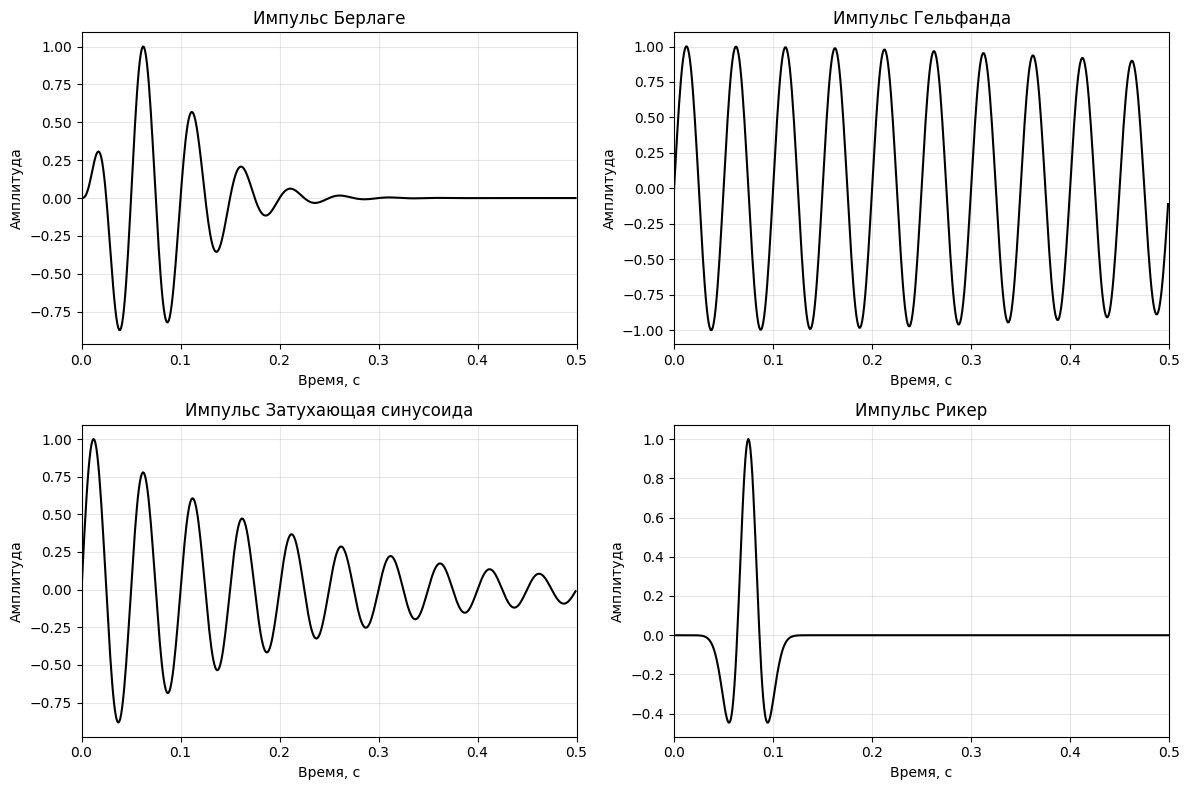

In [37]:
# Визуализация импульсов
plt.figure(figsize=(12, 8))
for i, (name, wavelet) in enumerate(impulses.items()):
    plt.subplot(2, 2, i+1)
    plt.plot(t_impulse, wavelet, 'k')
    plt.title(f'Импульс {name}')
    plt.xlabel('Время, с')
    plt.ylabel('Амплитуда')
    plt.xlim(0, t_max)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Свертка

In [39]:
# Подготовка временной оси с равномерным шагом
t_min = times_mid[0]
t_max_trace = times_mid[-1]
dt_trace = dt  # Используем тот же шаг, что и для импульсов
t_trace = np.arange(t_min, t_max_trace + dt_trace, dt_trace)

# Интерполяция коэффициентов отражения на равномерную сетку времени
R_interp = np.interp(t_trace, times_mid, R_clean)

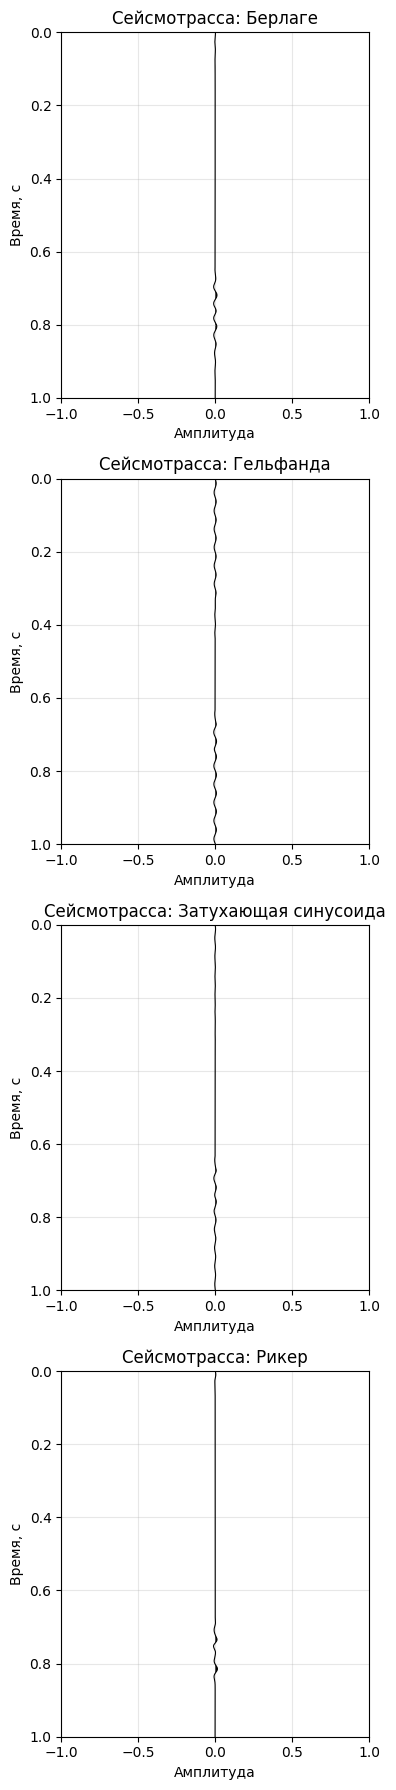

In [47]:
# Отображение свертки с каждым импульсом
plt.figure(figsize=(4, 18))

for i, (name, wavelet) in enumerate(impulses.items(), 1):
    # Свертка рефлективности с импульсом
    conv = np.convolve(R_interp, wavelet, mode='same')
    # Нормализация сейсмотрассы
    max_conv = np.max(np.abs(conv))
    if max_conv != 0:
        conv /= max_conv

    plt.subplot(len(impulses), 1, i)
    plt.plot(conv, t_trace, 'k', linewidth=0.8)
    plt.fill_betweenx(t_trace, 0, conv, where=conv >= 0, facecolor='black')
    plt.title(f'Сейсмотрасса: {name}')
    plt.xlabel('Амплитуда')
    plt.ylabel('Время, с')
    plt.xlim(-1, 1.)
    # plt.ylim(t_trace[-1], 0)  # Инвертируем ось Y
    plt.ylim(1, 0) 
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()